In [14]:
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import manifold
from sklearn import metrics
from tqdm.auto import tqdm
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score

import warnings
warnings.filterwarnings('ignore')

# For reproducibility
np.random.seed(42)

In [15]:
def load_data(datafile):
    """ Utility function to load the data files with correct dtypes """
    data = pd.read_csv(
        datafile
    )
    return data

def dataset_split(X, Y, ratio):
    """ Function to split the dataset into train and test """
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=ratio)
    return X_train, X_test, y_train, y_test

def score(y_true,y_pred): 
    """ Function to print the metrics of interest of the model """
    mse = mean_squared_error(y_true, y_pred) #set score here and not below if using MSE in GridCV
    r2 = r2_score(y_true, y_pred)
    ev = explained_variance_score(y_true, y_pred)
    print("MSE is: ", mse)
    print("R2 is: ", r2)
    print("Explained variance is:", ev)
    
def model_tune(model_name, params, X_train, y_train):
    if model_name == 'knn':
        model = KNeighborsRegressor(algorithm='auto')
    elif model_name == 'rf':
        model = RandomForestRegressor()
    elif model_name == 'regression':
        model = ElasticNet()
    else:
        print('Model unrecognised')
    # Tune the model with Bayesian optimisation
    opt = BayesSearchCV(model, param_grid, n_iter=30, cv=5, verbose=1)
    opt.fit(X_train, y_train)
    # With the following parameter combination being optimal
    print("Best parameter combo:", opt.best_params_)
    # Having the following score
    print("Best validation MSE:", opt.best_score_)
    return opt.best_estimator_

# Load the data

In [37]:
# Path to dataset
PATH = '/cdtshared/wearables/health_data_files/'

# Features from biobank
features = load_data(PATH+'dataset-with-preprocessing-done.csv')

features_of_interest = ['age_entry_years', 'sex', 'smoking', 'BMI', 'inc_ihd']
categorical_features = ['sex', 'smoking']
numeric_features = list(set(features_of_interest) - set(categorical_features))
Y = features['acc.overall.avg']
X = features[features_of_interest]

#Check for null values
X[X.isnull().any(axis=1)]

,age_entry_years,sex,smoking,BMI,inc_ihd


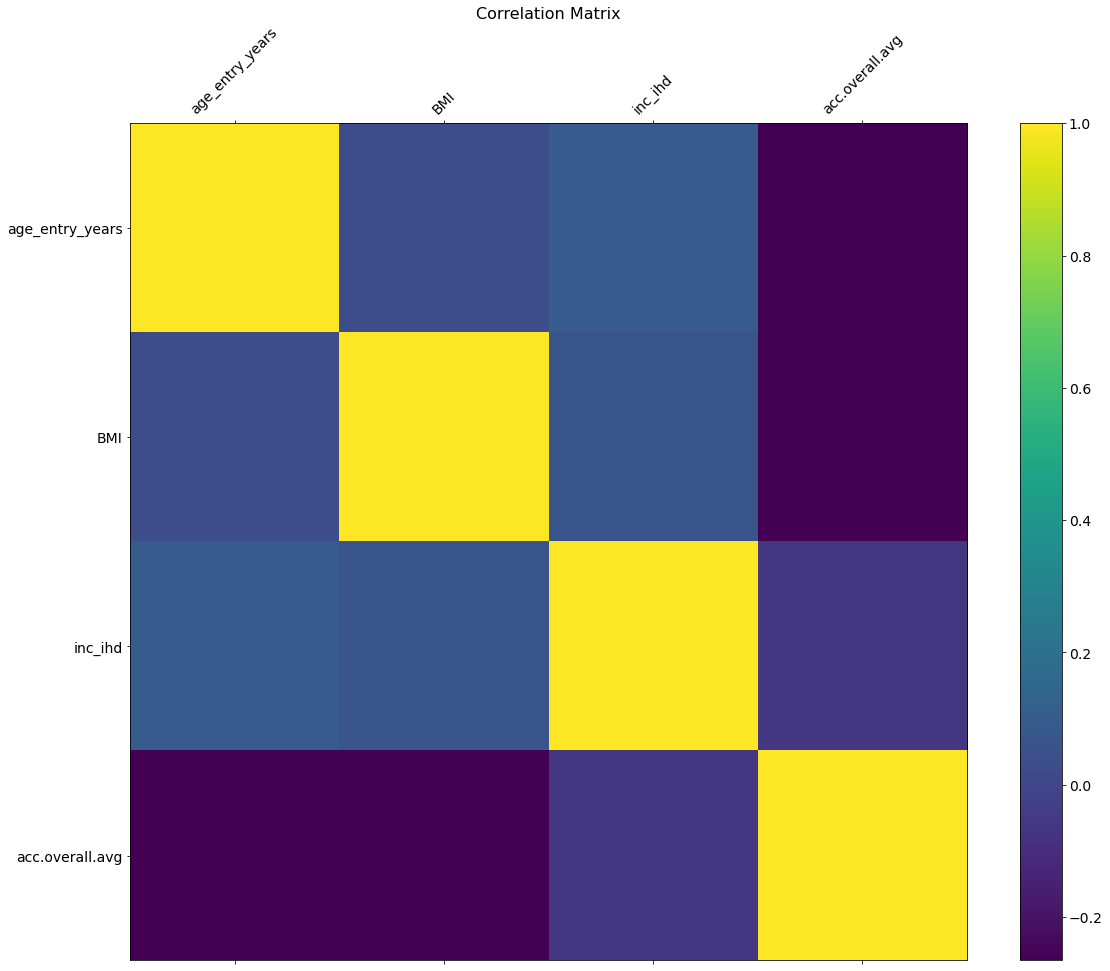

In [47]:
# There is no significant correlation between the features and the outcome

f = plt.figure(figsize=(19, 15))
plt.matshow(features[['age_entry_years', 'sex', 'smoking', 'BMI', 'inc_ihd', 'acc.overall.avg']].corr(), fignum=f.number)
plt.xticks(range(features[['age_entry_years', 'sex', 'smoking', 'BMI', 'inc_ihd', 'acc.overall.avg']].select_dtypes(['number']).shape[1]), features[['age_entry_years', 'sex', 'smoking', 'BMI', 'inc_ihd', 'acc.overall.avg']].select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(features[['age_entry_years', 'sex', 'smoking', 'BMI', 'inc_ihd', 'acc.overall.avg']].select_dtypes(['number']).shape[1]), features[['age_entry_years', 'sex', 'smoking', 'BMI', 'inc_ihd', 'acc.overall.avg']].select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

# Data preparation for training

In [17]:
# Encode the categorical variables
X_enc = pd.get_dummies(X, columns=categorical_features)

In [18]:
Y = Y.to_numpy()

In [19]:
# Split into training and testing, 80:20
X_train, X_test, y_train, y_test = train_test_split(X_enc, Y, test_size=0.2)

print("Shape of training set:", X_train.shape)
print("Shape of test set:", X_test.shape)

Shape of training set: (72994, 8)
Shape of test set: (18249, 8)


# Model Tuning

In [20]:
# Define the hyperparameters you want to sweep through (important it is manual for generalisation)
# C for regularisation if doing regression
# kernel if doing SVM for example

# In this case we are tuning for ElasticNet hyperparameters
# Regularisation constant
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
# Relative ratio of l1 vs l2 regularisation
l1_ratio = np.arange(0.0, 1.0, 0.1)

# Create the grid
param_grid = {'alpha': alpha,
               'l1_ratio': l1_ratio}

In [21]:
# Define the model you are interested in
model = ElasticNet()

In [22]:
# Skip to bayesian below if taking too long to compute
clf = GridSearchCV(model, param_grid, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])})

In [23]:
# Get the best model
model_best = clf.best_estimator_
# With the following parameter combination being optimal
print("Best parameter combo:", clf.best_params_)
# Having the following score
print("Best validation MSE:", clf.best_score_)

Best parameter combo: {'alpha': 0.001, 'l1_ratio': 0.0}
Best validation MSE: 0.13922009152681952


In [51]:
# Get the test set performance
score(y_test, model_best.predict(X_test))

MSE is:  56.23990444877787
R2 is:  0.13764092697751196
Explained variance is: 0.13777113826368415


In [25]:
# Try with Bayesian optimisation for faster computation of tuning
opt = BayesSearchCV(model, param_grid, n_iter=30, cv=5, verbose=1)
opt.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=5, estimator=ElasticNet(), n_iter=30,
              search_spaces={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                             'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
              verbose=1)

In [26]:
# Get the best model
model_best = opt.best_estimator_
# With the following parameter combination being optimal
print("Best parameter combo:", opt.best_params_)
# Having the following score
print("Best validation MSE:", opt.best_score_)

Best parameter combo: OrderedDict([('alpha', 0.001), ('l1_ratio', 0.0)])
Best validation MSE: 1.3922009152681952e-01


Best parameters: <br>
**alpha**:0.001 <br>
**l1_ratio**: 0 <br>

In [49]:
score(y_train, model_best.predict(X_train))

MSE is:  58.96746034066791
R2 is:  0.13950907105964772
Explained variance is: 0.13950907105964772


In [50]:
# Get the test set performance
score(y_test, model_best.predict(X_test))

MSE is:  56.23990444877787
R2 is:  0.13764092697751196
Explained variance is: 0.13777113826368415
